# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [X] Explore the data
    - [X] get to know the master dataset
    - [X] feature engineering
- [X] Modeling
    - [X] create, fit, use XGBoost
    - [X] gridsearch
    - [X] retrain model using best hyperparameters
    - [X] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro

# For data preparation
from sklearn.model_selection import train_test_split

# For modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05

In [2]:
def viz_correlation(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    
    # Use the default Pearson for continuous variables
    corr_matrix = dfx.corr(method ='pearson')

    # Setup
    fig, ax = plt.subplots(figsize=(16,8))

    # vmin and vmax control the range of the colormap
    sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
               vmin=-1, vmax=1)

    plt.title(graph_title)

    # Add tight_layout to ensure the labels don't get cut off
    plt.tight_layout()
    plt.show()

In [3]:
def viz_scatter(df, graph_title, col1, col2):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[col1], df[col2], alpha=0.5)
    plt.xlabel(col1) #x label
    plt.ylabel(col2) #y label
    plt.title(graph_title)
    plt.show()

In [4]:
def viz_pairplot(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    plt.figure(figsize=(16, 8))
    sns.pairplot(dfx)
    plt.title(graph_title)
    plt.show()

In [5]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [6]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

In [8]:
def viz_boxplot(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.boxplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [9]:
def viz_violin(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.violinplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [10]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    return plot_importance(booster=booster, ax=ax, **kwargs)

## ACQUIRE DATA

In [11]:
# Get the combined PEIMS and STAAR datasets
df = pd.read_csv('../data/inter/clean_efficient_2019.csv')

In [12]:
df.head()

,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses,Efficient
0,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633,0
1,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465,0
2,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481,0
3,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786,0
4,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0,0


## PREPARATION

In [13]:
X = df.drop("Efficient", axis=1)
y = df['Efficient']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493, stratify=y)

## MODELING

In [15]:
# Init classifier
xgb_cl = xgb.XGBClassifier(random_state=493)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=493,
              reg_alpha=0, reg_lambda=1, ...)

0.7888888888888889

In [16]:
# make predictions for test data
y_pred = xgb_cl.predict(X_test)
predictions = [round(value) for value in y_pred]

In [17]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.89%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

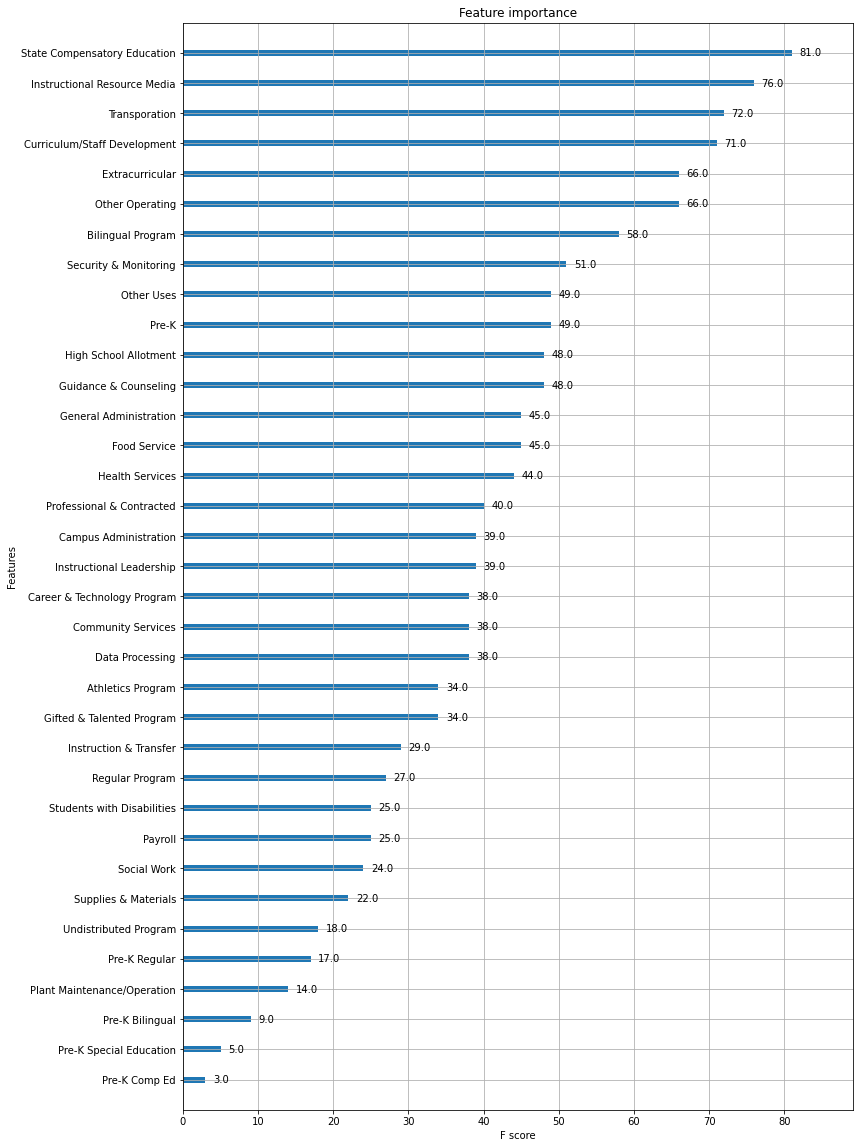

In [18]:
my_plot_importance(xgb_cl, (12, 20))

### Selection

In [21]:
df.columns

Index(['Payroll', 'Professional & Contracted', 'Supplies & Materials',
       'Other Operating', 'Instruction & Transfer',
       'Instructional Resource Media', 'Curriculum/Staff Development',
       'Instructional Leadership', 'Campus Administration',
       'Guidance & Counseling', 'Social Work', 'Health Services',
       'Transporation', 'Food Service', 'Extracurricular',
       'General Administration', 'Plant Maintenance/Operation',
       'Security & Monitoring', 'Data Processing', 'Community Services',
       'Regular Program', 'Gifted & Talented Program',
       'Career & Technology Program', 'Students with Disabilities',
       'State Compensatory Education', 'Bilingual Program',
       'High School Allotment', 'Pre-K', 'Pre-K Bilingual', 'Pre-K Comp Ed',
       'Pre-K Regular', 'Pre-K Special Education', 'Athletics Program',
       'Undistributed Program', 'Other Uses', 'Efficient'],
      dtype='object')

In [27]:
dfx = df[['State Compensatory Education',
          'Instructional Resource Media',
          'Transporation',
          'Curriculum/Staff Development',
          'Extracurricular',
          'Other Operating',
          'Bilingual Program',
          'Security & Monitoring',
          'Other Uses',
          'Pre-K',
          'High School Allotment',
          'Guidance & Counseling',
          'General Administration',
          'Food Service',
          'Health Services',
          'Professional & Contracted',
          'Efficient'
         ]]

In [28]:
dfx.to_csv('../data/inter/clean_2019.csv', index=False)